# Hyperpolarized C13 EPI Reconstruction Demo

The C13 echo-planar imaging (EPI) sequence used to acquire this demonsration data is built off of the product/clinical 1H EPI sequence on GE scanners. It utilizes the Orchestra reconstruction to load and process the C13 data (phase correction, ramp-sampling, etc.) for both offline and on-scanner reconstruction and dicom generation.

Because of software licenses we cannot publicly share that code in its entirety. 
Please contact jeremy.gordon@ucsf.edu or peder.larson@ucsf.edu if you  would like access to the pulse sequence and reconstruction code.

This pseudo reconstruction code will pre-whiten the multichannel data and then generate coil combined images using the pyruvate data to estimate the sensitivity map. More information on this 'refpeak' reconstruction can be found in Zhu et al., "Coil combination methods for multi-channel hyperpolarized 13C imaging data from human studies" 
https://doi.org/10.1016/j.jmr.2019.01.015

## Install code, setup path

To run this code you will need to clone the hyperpolarized MRI toolbox
repository from github and add it to your matlab path. 
This can be done with the following command:
'git clone https://github.com/LarsonLab/hyperpolarized-mri-toolbox/'

This also requires the Optimization Toolbox (Matlab) or 'optim' toolbox (Octave) for the kinetic model fitting and Image Processing Toolbox ('image' in Octave) for plots


In [1]:
% setup hyperpolarized-mri-toolbox
cd ../
if exist('startup.m')
    startup
else
    cd ../
    startup
end
cd 'reconstruction/EPI demo'

loading optim
loading image
loading io
loading statistics
loading signal


In [2]:
%% Load the EPI data
close all, clear all, clc
load brain_data_demo

X = size(chim,1)
Y = size(chim,2)
numCoils = size(chim,3)
numSlices = size(chim,4)
numFreqs = 3; %[Pyruvate, Lactate, Bicarbonate]
numFrames = 20;
chim = reshape(chim,[X Y numCoils numSlices numFreqs numFrames]);
chim = permute(chim,[1 2 4 3 7 5 6]);
size(chim)


X =  16
Y =  16
numCoils =  32
numSlices =  8
ans =

   16   16    8   32    1    3   20



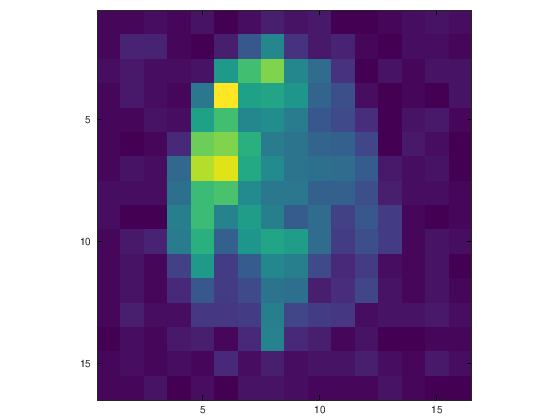

In [3]:
% pyruvate image slice 4, channel 12, time point 3

imagesc(abs(chim(:,:,4,12,1,1,3))), axis square

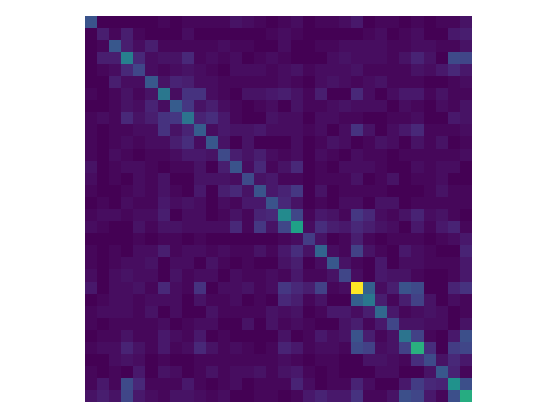

In [4]:
%% Pre-whiten the data
%Ensure you use noise-only data for pre-whitening
noise_data = chim(:,:,1,:,1,1,20);
[chim, ncm] = prewhitening_cc(chim, noise_data);

%Note that Ch. 23 is 'hot' relative to the other 31 elements
figure,imagesc(abs(ncm)); axis image off;


In [5]:
%% Reconstruct using the 'refpeak' method and sum-of-squares
im_refpeak = RefPeak_cc(chim);
im_sos = Sum_of_Square_cc(chim);

im_refpeak = squeeze(im_refpeak);
im_sos = squeeze(im_sos);


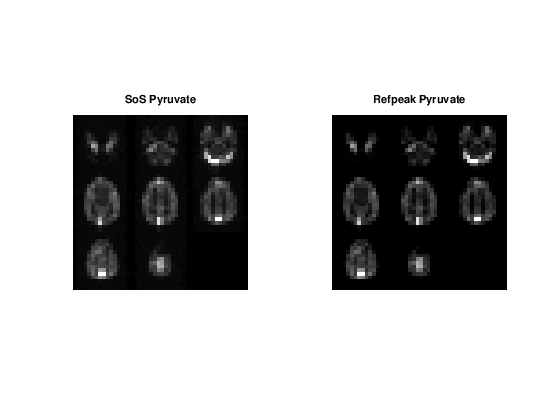

In [9]:
%% Compare area under the curve (AUC) for the two reconstructions

%Subtle difference for high SNR metabolites (pyruvate)
figure;
pyr_sos = abs(squeeze(sum(im_sos(:,:,:,1,:),5)));
clim = [0.05 0.8].*max(pyr_sos(:));
subplot(121),montage(permute(pyr_sos,[1 2 4 3]),'DisplayRange',clim,'Size',[3 3])
title('SoS Pyruvate')

pyr_ref = abs(squeeze(sum(im_refpeak(:,:,:,1,:),5)));
clim = [0.05 0.8].*max(pyr_ref(:));
subplot(122),montage(permute(pyr_ref,[1 2 4 3]),'DisplayRange',clim,'Size',[3 3])
title('Refpeak Pyruvate')
%set(gcf,'units','normalized','outerposition',[0.2 0.2 0.6 0.5])




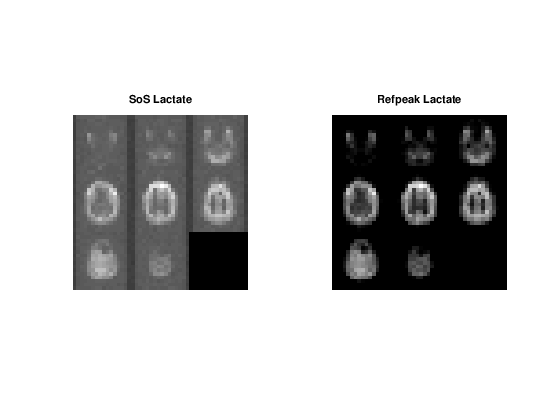

In [7]:
%More difference for medium SNR metabolites (lactate)
figure;
lac_sos = abs(squeeze(sum(im_sos(:,:,:,2,:),5)));
clim = [0.05 1].*max(lac_sos(:));
subplot(121),montage(permute(lac_sos,[1 2 4 3]),'DisplayRange',clim,'Size',[3 3])
title('SoS Lactate')

lac_ref = abs(squeeze(sum(im_refpeak(:,:,:,2,:),5)));
clim = [0.05 1].*max(lac_ref(:));
subplot(122),montage(permute(lac_ref,[1 2 4 3]),'DisplayRange',clim,'Size',[3 3])
title('Refpeak Lactate')
%set(gcf,'units','normalized','outerposition',[0.2 0.2 0.6 0.5])



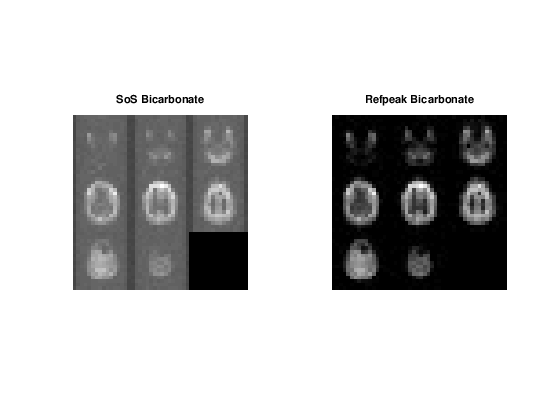

In [8]:
%Largest difference for noisiest metabolites (bicarbonate)
figure;
bic_sos = abs(squeeze(sum(im_sos(:,:,:,2,:),5)));
clim = [0.01 1].*max(bic_sos(:));
subplot(121),montage(permute(bic_sos,[1 2 4 3]),'DisplayRange',clim,'Size',[3 3])
title('SoS Bicarbonate')

bic_ref = abs(squeeze(sum(im_refpeak(:,:,:,2,:),5)));
clim = [0.01 1].*max(bic_ref(:));
subplot(122),montage(permute(bic_ref,[1 2 4 3]),'DisplayRange',clim,'Size',[3 3])
title('Refpeak Bicarbonate')
%set(gcf,'units','normalized','outerposition',[0.2 0.2 0.6 0.5])

In [6]:
%% Use the 'refpeak' combined data to estimate kPL, AUC ratio, and mean arrival time

%Data were acquired with a variable flip angle across metabolites, constant
%through time.
flips = [20 30 30].* pi./180;
flips = repmat(flips,[numFrames 1]);
TR = 3; %temporal resolution (s)

%Intialize fit parameters
clear params_fixed params_est params_fit
R1P_est = 1/30; R1L_est = 1/25;  kPL_est = 0.02;
R1B_est = 1/30; kPB_est = 0.005;
params_fixed.R1P = R1P_est; params_fixed.R1L = R1L_est;
params_est.kPL = kPL_est; params_est.kPB = kPB_est; 
params_est.R1B = R1B_est;

==== Computing parameter map ====
    fit_pyr_kinetics at line 222 column 36
kPL = 0.024 kPB = 0.0087 R1B = 0.02 S0_L = 5.2 S0_B = 1.8 
k_{PL} = 0.023756 1/s, k_{PB} = 0.0086918 1/s


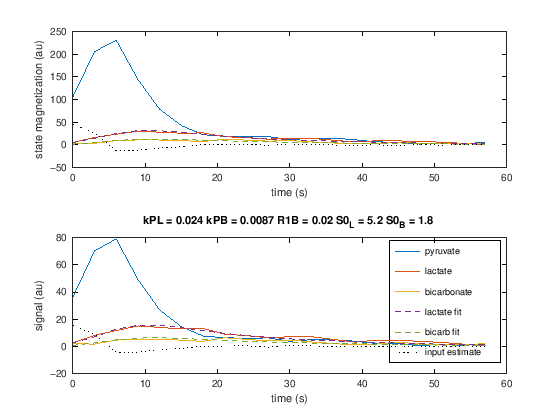

In [7]:
% sample fitting

% select voxel
ii = 12;
jj = 8;
kk = 5;

plot_flag = 1;

params_fit = fit_pyr_kinetics(abs(squeeze(im_refpeak(ii,jj,kk,:,:))),TR,flips',params_fixed,params_est, [], plot_flag);
legend('pyruvate','lactate','bicarbonate')
% fits are dashed lines

disp(['k_{PL} = ' num2str(params_fit.kPL) ' 1/s, k_{PB} = ' num2str(params_fit.kPB) ' 1/s'])

In [10]:
%Threshold based on pyruvate AUC
mask = zeros(X,Y,numSlices);
thresh = 0.05;
mask(pyr_ref > thresh.*max(pyr_ref(:))) = 1;

im_refpeak_masked = im_refpeak .* repmat(mask, [1 1 1 numFreqs numFrames]);

params_fit = fit_pyr_kinetics(abs(im_refpeak_masked), TR, flips', params_fixed, params_est);
kpl = params_fit.kPL;
kpb = params_fit.kPB;

2% complete
2% complete
2% complete
2% complete
3% complete
3% complete
3% complete
3% complete
3% complete
3% complete
4% complete
4% complete
4% complete
4% complete
4% complete
4% complete
4% complete
4% complete
4% complete
5% complete
5% complete
5% complete
5% complete
5% complete
5% complete
6% complete
6% complete
7% complete
7% complete
7% complete
7% complete
8% complete
8% complete
8% complete
8% complete
8% complete
8% complete
8% complete
8% complete
8% complete
8% complete
8% complete
8% complete
8% complete
8% complete
9% complete
9% complete
9% complete
9% complete
15% complete
15% complete
15% complete
15% complete
15% complete
15% complete
15% complete
15% complete
15% complete
15% complete
15% complete
16% complete
16% complete
16% complete
16% complete
16% complete
16% complete
16% complete
16% complete
16% complete
16% complete
16% complete
16% complete
16% complete
17% complete
17% complete
17% complete
17% complete
17% complete
17% complete
17% complete
17% compl

In [15]:
lp_ratio = compute_AUCratio(abs(im_refpeak(:,:,:,[1 2],:))) .* mask;
bp_ratio = compute_AUCratio(abs(im_refpeak(:,:,:,[1 3],:))) .* mask;

In [20]:
mean_time_map = zeros(X,Y,numSlices,numFreqs);
mean_time_map(:,:,:,1) = compute_mean_time(abs(squeeze(im_refpeak(:,:,:,1,:))),TR) .* mask;
mean_time_map(:,:,:,2) = compute_mean_time(abs(squeeze(im_refpeak(:,:,:,2,:))),TR) .* mask;
mean_time_map(:,:,:,3) = compute_mean_time(abs(squeeze(im_refpeak(:,:,:,3,:))),TR) .* mask;


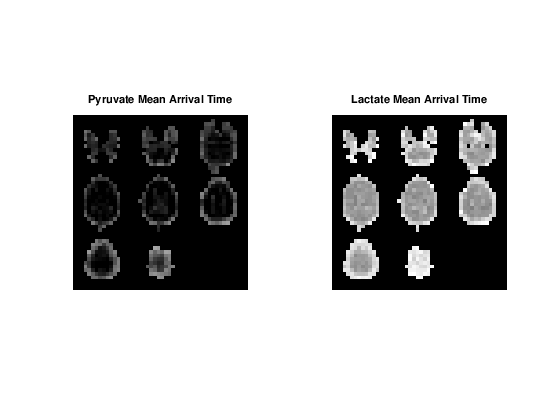

In [21]:
%% Display a subset of the results
%Note the difference in mean arrival time between pyruvate and lactate
figure;
subplot(121),montage(permute(mean_time_map(:,:,:,1),[1 2 4 3]),'DisplayRange', ... 
    [10 30],'Size',[3 3])
title('Pyruvate Mean Arrival Time')
subplot(122),montage(permute(mean_time_map(:,:,:,2),[1 2 4 3]),'DisplayRange', ... 
    [10 30],'Size',[3 3])
title('Lactate Mean Arrival Time')
%set(gcf,'units','normalized','outerposition',[0.2 0.2 0.6 0.5])



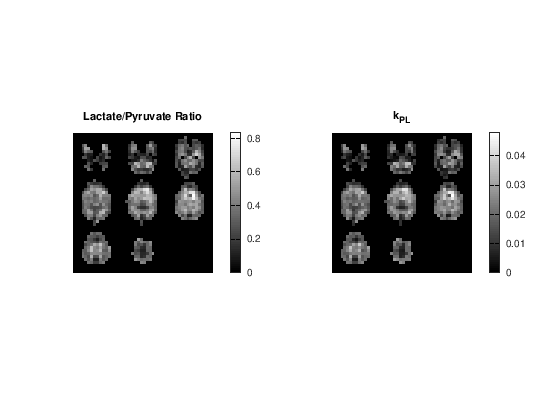

In [16]:
%Note the similarity between kPL and lactate-to-pyuvate AUC ratio maps
figure;
subplot(121),montage(permute(lp_ratio,[1 2 4 3]),'Size',[3 3], ... 
    'DisplayRange',[0 1].*max(lp_ratio(:)))
title('Lactate/Pyruvate Ratio')
colorbar
subplot(122),montage(permute(kpl,[1 2 4 3]),'Size',[3 3], ...
    'DisplayRange',[0 1].*max(kpl(:)))
title('k_{PL}')
colorbar
%set(gcf,'units','normalized','outerposition',[0.2 0.2 0.6 0.5])

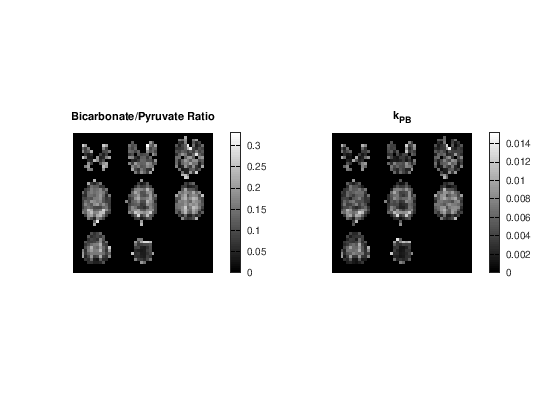

In [14]:
%Note the similarity between kPL and lactate-to-pyuvater AUC ratio maps
figure;
subplot(121),montage(permute(bp_ratio,[1 2 4 3]),'Size',[3 3], ... 
    'DisplayRange',[0 1].*max(bp_ratio(:)))
title('Bicarbonate/Pyruvate Ratio')
colorbar
subplot(122),montage(permute(kpb,[1 2 4 3]),'Size',[3 3], ...
    'DisplayRange',[0 1].*max(kpb(:)))
title('k_{PB}')
colorbar
%set(gcf,'units','normalized','outerposition',[0.2 0.2 0.6 0.5])